# the version THree of our classifier 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, r2_score, mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error, mean_squared_log_error
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler

def perform_neural_network_classification(csv_file_path):
    """
    Performs neural network binary classification on a dataset, calculates
    various classification and regression metrics, generates a confusion
    matrix heatmap, and saves all metrics to an Excel file.

    This version includes an improved model architecture and training
    process with regularization and callbacks to prevent overfitting and
    optimize performance.

    Args:
        csv_file_path (str): The path to the CSV file. All columns except the last
                             are treated as features (X), and the last column,
                             which should contain 0s and 1s, is the target variable (y).
    """
    try:
        # Load the dataset
        df = pd.read_csv(csv_file_path)

        # Separate features (X) and target (y)
        X = df.iloc[:, :-1]  # All columns except the last
        y = df.iloc[:, -1]   # The last column (0 or 1)

        # Split the data into training and testing sets (80/20 split)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Standardize the data to help the neural network converge faster
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # --- Define Callbacks for Training ---
        # EarlyStopping: Stop training when validation loss stops improving for a certain number of epochs.
        # This prevents overfitting and saves training time.
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=50,  # Number of epochs with no improvement after which training will be stopped
            restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
        )

        # ReduceLROnPlateau: Reduce the learning rate when a metric has stopped improving.
        # This can help the model find a better minimum in the loss function.
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2, # Factor by which the learning rate will be reduced
            patience=20, # Number of epochs with no improvement after which learning rate will be reduced
            min_lr=0.00001
        )

        # --- Improved Neural Network Model Setup ---
        model = Sequential()
        
        # Input layer and first hidden layer with L2 regularization to prevent overfitting
        model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],),
                        kernel_regularizer=l2(0.001))) # L2 regularization

        # Dropout layer to prevent overfitting
        model.add(Dropout(0.4))
        
        # Second hidden layer
        model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))

        model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))

        model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))

        
        # Output layer for binary classification with a single neuron and sigmoid activation
        model.add(Dense(1, activation='sigmoid'))

        # Compile the model with the Adam optimizer and binary cross-entropy loss
        model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
        
        # Print the model summary
        print("Model Summary:")
        model.summary()
        
        # Train the model with the added callbacks
        print("\nTraining Neural Network model...")
        history = model.fit(
            X_train_scaled, y_train,
            epochs=2000,  # Set a high number of epochs, but EarlyStopping will handle stopping
            batch_size=32,
            validation_split=0.2,  # Use 20% of the training data for validation
            callbacks=[early_stopping, reduce_lr], # Pass the callbacks here
            verbose=1  # Show training progress
        )
        
        # --- Save the Trained Model ---
        # Save the entire model (architecture, weights, and optimizer state)
        model_path = 'best_model.keras'
        model.save(model_path)
        print(f"\nModel saved successfully to '{model_path}'")

        # --- Make Predictions ---
        # The model predicts a probability. We round it to get a binary class (0 or 1).
        y_pred_proba = model.predict(X_test_scaled).flatten()
        y_pred = (y_pred_proba > 0.5).astype("int32")

        # --- 1. Calculate Classification Metrics ---
        print("\n--- Neural Network Model Performance Metrics ---")

        # Accuracy Score
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.4f}")

        # Classification Report (Precision, Recall, F1-Score)
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # ROC AUC Score
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f"ROC AUC Score: {roc_auc:.4f}")
        
        # --- 2. Calculate Regression Metrics on Probabilities ---
        print("\n--- Regression Metrics on Predicted Probabilities ---")

        # R-squared (Coefficient of Determination)
        r2 = r2_score(y_test, y_pred_proba)
        print(f"R-squared (R2): {r2:.4f}")

        # Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, y_pred_proba)
        print(f"Mean Absolute Error (MAE): {mae:.4f}")

        # Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_pred_proba)
        print(f"Mean Squared Error (MSE): {mse:.4f}")

        # Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mse)
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

        # Mean Absolute Percentage Error (MAPE)
        mape = np.mean(np.abs((y_test - y_pred_proba) / (y_test + 1e-8))) * 100
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

        # Mean Squared Log Error (MSLE) - check for negative values
        msle = mean_squared_log_error(y_test + 1e-8, y_pred_proba + 1e-8)
        print(f"Mean Squared Log Error (MSLE): {msle:.4f}")

        # --- 3. Save Metrics to Excel ---
        metrics_data = {
            'Metric': ['Accuracy', 'ROC AUC', 'R2 Score', 'MAE', 'MSE', 'RMSE', 'MAPE', 'MSLE'],
            'Value': [accuracy, roc_auc, r2, mae, mse, rmse, mape, msle]
        }
        
        metrics_df = pd.DataFrame(metrics_data)
        excel_path = 'nn_performance_metrics.xlsx'
        metrics_df.to_excel(excel_path, index=False)
        print(f"\nModel performance metrics saved to '{excel_path}'")

        # --- 4. Generate Confusion Matrix Plot ---
        cm = confusion_matrix(y_test, y_pred)
        
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        
        plot_path = 'confusion_matrix.svg'
        plt.savefig(plot_path, format='svg')
        print(f"\nConfusion matrix plot saved to '{plot_path}'")
        plt.show()

    except FileNotFoundError:
        print(f"Error: The file '{csv_file_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")


Model Summary:


d:\River-Flood-Prediction\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,433 (72.00 KB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 0 (0.00 B)


Training Neural Network model...
Epoch 1/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5061 - loss: 0.8675 - val_accuracy: 0.5150 - val_loss: 0.8159 - learning_rate: 0.0010
Epoch 2/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5133 - loss: 0.7842 - val_accuracy: 0.5194 - val_loss: 0.7580 - learning_rate: 0.0010
Epoch 3/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5169 - loss: 0.7411 - val_accuracy: 0.5044 - val_loss: 0.7292 - learning_rate: 0.0010
Epoch 4/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5233 - loss: 0.7182 - val_accuracy: 0.5106 - val_loss: 0.7129 - learning_rate: 0.0010
Epoch 5/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5191 - loss: 0.7071 - val_accuracy: 0.5000 - val_loss: 0.7047 - learning_rate: 0.0010
Epoch 6/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5288 - loss: 0.7008 - val_accuracy: 0.5113 - val_loss: 0.7004 - learning_rate: 0.0010
Epoch 7/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 

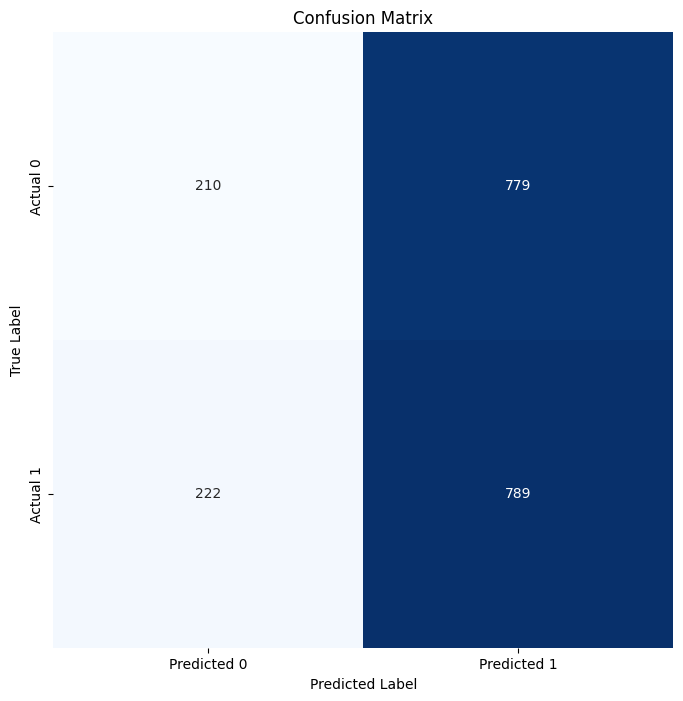

In [2]:
perform_neural_network_classification("../../mapped_dataset_Normalized_version.csv")